In [1]:
import time
import numpy as np
import gym
import arlenvs


### Environment Creation
    
* uncomment the desired environment
* init env class

In [2]:
# env_name = "MexicanWorld-v0"
# env_name = "ContinuousMexicanWorld-v0"
# env_name = "MarsLander-v0"  # gym.make accepts level=1, level=2 or level=3 as kwarg, to control the difficultly
# env_name = "GettingOverIt-v0"
# env_name = "PlanetWorld-v0"
# env_name = 'GameOfDrones-v0'
env_name = "FlappyBird-v0"
# env_name = "DronePathFinding-v0"
# env_name = "DronePathTracking-v0"
# env_name = "HaxBall-v0"
# unwrapped to get rid of this TimeLimitWrapper, which might reset the environment twice and thus breaks ergodicity
env = gym.make(env_name).unwrapped


### Init q_table and policy



In [41]:
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.shape
print("State size ", state_size)
print("State bounds: ", env.observation_space.low, env.observation_space.high)
state_dim = env.observation_space.high -env.observation_space.low +1
print("State dim: ", state_dim )

print("state sample: ", env.observation_space.sample())


Action size  2
State size  (4,)
State bounds:  [0 0 0 0] [ 1 26 30 80]
State dim:  [ 2 27 31 81]
state sample:  [ 1 13  4 44]


In [42]:
table = np.zeros(state_dim)
print(table.shape)

(2, 27, 31, 81)


In [43]:
qtable = dict()
for a in range(action_size):
    qtable[a] = np.zeros(state_dim)

print(qtable.keys())

dict_keys([0, 1])


In [44]:
policy = np.zeros(state_dim)

### SARSA learning function

In [45]:
epsilon = 0.7
total_episodes = 2000000
alpha = 0.1
gamma = 0.8
number_of_actions = len(qtable.keys())
render_every = 500000
max_steps = 10000

In [46]:
# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.0001             # Exponential decay rate for exploration prob

In [47]:
def epsilon_greedy(state, number_of_actions):
    if np.random.rand() > epsilon:
        action = policy[tuple(state)]
        return action
    else:
        # Taking random action from environment
        action = env.action_space.sample()
        return action

In [48]:
def train_sarsa():

    # Start the training
    for i in range(total_episodes):
        state = env.reset() # reseting the environment
        # Set a flag for when environment to be rendered
        if i % render_every is 0:
            print(i)
            do_rendering = True
        else:
            do_rendering = False
        episode_done = False
        while not episode_done:
            # Getting an action
            action = epsilon_greedy(state, number_of_actions)

            # Taking the action in the environment
            next_states, reward, episode_done, _ = env.step(action)

            qtable[action][tuple(state)] += alpha * (
                    reward + (gamma * qtable[policy[tuple(next_states)]][tuple(next_states)] 
                              - qtable[action][tuple(state)]))
            # Update policy
            policy[tuple(state)] = action
            temp_max_Q = np.abs(qtable[action][tuple(state)])

            for action_pol in range(len(qtable.keys())):
                if qtable[action_pol][tuple(state)] > temp_max_Q:
                    policy[tuple(state)] = action
                    temp_max_Q = qtable[action_pol][tuple(state)]

            # print("New best policy for state: ",self.discrete_states, self.policy[self.discrete_states], episode_done, self.take_off_procedure - current_step)
            if do_rendering:
                env.render()

            if episode_done:
                env.close()
                break

            states = next_states
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * i)


In [49]:

def qlearn():
    # 2 For life or until learning is stopped
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        state_idx = tuple(state)
        step = 0
        done = False
        
        if episode % render_every is 0:
            print(episode)
            do_rendering = True
        else:
            do_rendering = False

        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            # Getting an action
            action = epsilon_greedy(state, number_of_actions)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, _ = env.step(action)
            new_state_idx = tuple(new_state)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            qtable[action][state_idx] = qtable[action][state_idx] + alpha * (reward + gamma * 
                                        np.max([tab[new_state_idx] for tab in qtable.values()]) - qtable[action][state_idx])

            # Our new state is state
            state = new_state
            state_idx = tuple(state)
            
            
            if do_rendering:
                env.render()
            # If done : finish episode
            if done == True:
                env.close()
                break

        episode += 1

        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)



### Agent Learning

In [24]:
train_sarsa()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000


In [50]:
qlearn()

0
500000
1000000
1500000


### Testing agents

In [51]:
def restore_policy():
    """
    Restoring policy from Q_Table.
    :return:
    """
    STATE_VALUE_BUCKETS = list(qtable[0].shape)
    print(STATE_VALUE_BUCKETS)
    
    for i in range(STATE_VALUE_BUCKETS[0]):
        for j in range(STATE_VALUE_BUCKETS[1]):
            for k in range(STATE_VALUE_BUCKETS[2]):
                for l in range(STATE_VALUE_BUCKETS[3]):
                    policy[i, j, k, l] = np.argmax(np.array([qtable[action][i, j, k, l] for action in range(action_size)]))

restore_policy()

[2, 27, 31, 81]


In [54]:
env.reset()
rewards = []
total_test_episodes = 10

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        env.render()
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = policy[tuple(state)]
        
        new_state, reward, done, info = env.step(action)
        # For very fast running environments ...
        time.sleep(0.05)
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            print ("Score", total_rewards, "steps, ", step)
            break
            
        state = new_state
        
env.close()

print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
Score 110 steps,  73
****************************************************
EPISODE  1
Score 5 steps,  66
****************************************************
EPISODE  2
Score -130 steps,  57
****************************************************
EPISODE  3
Score -595 steps,  26
****************************************************
EPISODE  4
Score -655 steps,  22
****************************************************
EPISODE  5
Score 1745 steps,  182
****************************************************
EPISODE  6
Score -25 steps,  64
****************************************************
EPISODE  7
Score -610 steps,  25
****************************************************
EPISODE  8
Score -580 steps,  27
****************************************************
EPISODE  9
Score -370 steps,  41
Score over time: -110.5


In [52]:
mask = policy > 0
print(mask.sum(), policy.size)

265 135594


### Start environment

In [73]:

state = env.reset()

counter = 0
time_start = time.time()

#while True:
for i in range(1000):
  env.render(mode="human")

  action = env.action_space.sample()

  state, reward, done, _ = env.step(0)

  print(reward)

  # For very fast running environments ...
  time.sleep(0.02)

  if done:
    print("Resetting")
    env.reset()
  #end
#end

env.close()

print("time consumed", time.time() - time_start)

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
-985
Resetting
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
-985
Resetting
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

KeyboardInterrupt: 

### Monte Carlo

In [3]:
from collections import defaultdict
from time import perf_counter
import sys
import matplotlib.pyplot as plt

In [15]:
env.reset()

(0, 10, 12, 58)

In [39]:
train_episodes = 500000
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA, dtype=float))
discount_factor = 0.9  
epsilon = 0.1
env_max_steps = 10000
render = False
test_episodes = 1000
train_rewards = []

In [40]:
def make_epsilon_greedy_policy():
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """

    def policy_fn(observation):
        prob = np.ones(nA, dtype=float) * epsilon / nA
        optimal_action = np.argmax(Q[tuple(observation)])
        prob[optimal_action] += (1.0 - epsilon)
        return prob

    return policy_fn

In [41]:
def mc_control_train():
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    # Keeps track of sum and count of returns for each state
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # A nested dictionary that maps state -> (action -> action-value).
    policy_fn = make_epsilon_greedy_policy()
    counter = perf_counter()

    for i_episode in range(1, train_episodes + 1):
        episode = []
        state = env.reset()
        
        if i_episode % 5000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, train_episodes), end="")
            print('no of states explored:', len(Q.keys()))
            print('Time taken:', (perf_counter() - counter) / 60, 'minutes')
            counter = perf_counter()
#             render = True
            sys.stdout.flush()
        else:
            render = False

        reward_episode = 0.0
        for step in range(env_max_steps):
            if state in Q:
                prob_values = policy_fn(state)
                action = np.random.choice(np.arange(nA), p=prob_values)
            else:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            episode.append((next_state, action, reward))
            reward_episode += reward

            if render:
                env.render(mode='rgb_array')

            if done:
                env.close()
                break
                
            state = next_state

        train_rewards.append(reward_episode)
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurrence of the (state, action) pair in the episode
            first_occurrence_idx = next(i for i, x in enumerate(episode)
                                        if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurrence
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurrence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    return train_rewards

In [42]:
rewards = mc_control_train()

Episode 5000/500000.no of states explored: 2334
Time taken: 0.45913260866667166 minutes
Episode 10000/500000.no of states explored: 2842
Time taken: 0.5487417518666613 minutes
Episode 15000/500000.no of states explored: 3105
Time taken: 0.4289050693166852 minutes
Episode 20000/500000.no of states explored: 3277
Time taken: 0.460082810999999 minutes
Episode 25000/500000.no of states explored: 3399
Time taken: 0.47019879903333883 minutes
Episode 30000/500000.no of states explored: 3523
Time taken: 0.4288399526166662 minutes
Episode 35000/500000.no of states explored: 3633
Time taken: 0.4746069157500036 minutes
Episode 40000/500000.no of states explored: 3721
Time taken: 0.4408121194666819 minutes
Episode 45000/500000.no of states explored: 3799
Time taken: 0.44097264404999803 minutes
Episode 50000/500000.no of states explored: 3864
Time taken: 0.46920781653331384 minutes
Episode 55000/500000.no of states explored: 3922
Time taken: 0.44884104831665655 minutes
Episode 60000/500000.no of st

Episode 470000/500000.no of states explored: 5065
Time taken: 0.48000921839999744 minutes
Episode 475000/500000.no of states explored: 5068
Time taken: 0.4561602115999752 minutes
Episode 480000/500000.no of states explored: 5070
Time taken: 0.43574383441664394 minutes
Episode 485000/500000.no of states explored: 5072
Time taken: 0.45692237198333413 minutes
Episode 490000/500000.no of states explored: 5075
Time taken: 0.45081948134999644 minutes
Episode 495000/500000.no of states explored: 5078
Time taken: 0.45050616468330795 minutes
Episode 500000/500000.no of states explored: 5085
Time taken: 0.4633399779500299 minutes


/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/sayanta/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


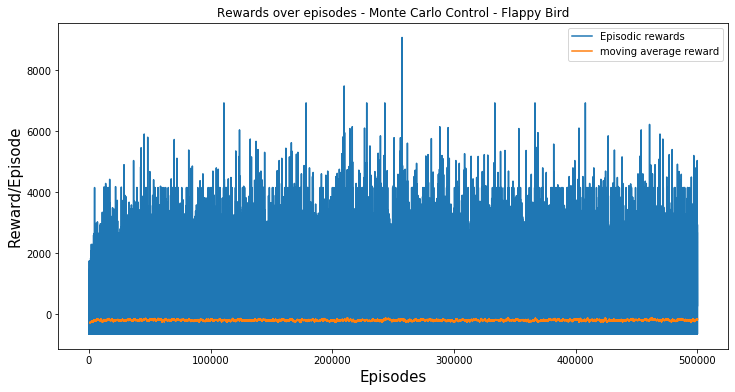

In [45]:
import pandas as pd

rew_df = pd.DataFrame(rewards, columns=['rewards'])
# Rolling mean
close_px = rew_df['rewards']
mavg = close_px.rolling(window=1000).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='Episodic rewards')
mavg.plot(label='moving average reward')
plt.xlabel('Episodes',fontsize=15)
plt.ylabel('Reward/Episode',fontsize=15)
plt.title('Rewards over episodes - Monte Carlo Control - Flappy Bird')
plt.legend()
plt.savefig('flappy_bird_mc.pdf')